# Investigate temperature change potential of different aerosol forcing time series

This is a bit circular as we need the non-aerosol forcing first. Could come after the AR6

**DO WE STILL USE THIS? I reckon it can be deleted and removed from process chain**
- think it is still used for historical temperature assessment.

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as pl
import os
import urllib
import json
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
from scipy.optimize import root
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from fair.forcing.ghg import etminan
from fair.constants import molwt
import tqdm.autonotebook as tqdman
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import matplotlib.gridspec as gridspec
import random
from tqdm import tqdm_notebook

from ar6.utils.h5 import *
from ar6.utils.statistics import rmse, weighted_percentile
from ar6.utils.ensemble import knutti_score
from ar6.utils import check_and_download
from ar6.forcing import ghan, aerocom_n

from openscm_units import unit_registry as ur
from scmdata import ScmRun, run_append

import openscm_twolayermodel
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel
from openscm_twolayermodel.base import Model

import h5py

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

## Construct CMIP6 emissions-based forcing


The CEDS emissions are everything MAGICC Fossil and Industrial in RCMIP emissions, and RCMIP category agriculture included as part of LULUC.

From RCMIP:
- subtract Emissions|\[species\]|MAGICC Fossil and Industrial
- subtract Emissions|\[species\]|MAGICC AFOLU|Agriculture
- add new CEDS dataset.

In [3]:
check_and_download(
    '../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv'
)
    
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None
emissions

,SO2,BC,OC,NH3,NOx
year,,,,,
1750,2.440048,2.097771,15.447668,6.927690,12.735212
1751,2.408379,2.072926,15.188717,6.860142,12.592303
1752,2.397116,2.064312,15.034476,6.819482,12.594270
1753,2.410693,2.071951,15.182545,6.881439,12.539820
1754,2.462065,2.099350,15.558773,7.015189,12.636837
...,...,...,...,...,...
2096,31.757785,2.800165,15.001741,66.175403,79.831397
2097,31.523938,2.762863,14.886222,65.973947,79.296580
2098,31.290090,2.725561,14.770703,65.772490,78.761762


## Get new emissions from CEDS

to do: save processed emissions as a new rcmip like file

In [4]:
# nice todo here would be to verify that extracted files exist and delete zip if so

check_and_download(
    '../data_input_large/CEDS_v_2020_09_11_emissions.zip',
    'https://zenodo.org/record/4025316/files/CEDS_v_2020_09_11_emissions.zip'
)

In [5]:
import zipfile
with zipfile.ZipFile('../data_input_large/CEDS_v_2020_09_11_emissions.zip', 'r') as zip_ref:
    zip_ref.extractall('../data_input_large/CEDS_v_2020_09_11_emissions/')

In [6]:
emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

In [7]:
emissions-df_emissions

,BC,NH3,NOx,OC,SO2
year,,,,,
1750,1.580773,3.389110,12.543098,13.218007,1.964854
1751,1.554720,3.311554,12.399677,12.952248,1.929344
1752,1.544896,3.260887,12.401127,12.791206,1.915083
1753,1.551329,3.312840,12.346165,12.932487,1.926051
1754,1.577521,3.436588,12.442665,13.301934,1.974608
...,...,...,...,...,...
2096,1.239827,4.946155,9.044625,10.932323,2.047505
2097,1.232528,4.947864,8.983415,10.874837,2.043344
2098,1.225230,4.949573,8.922205,10.817351,2.039184


In [8]:
global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,NH3,NOx,OC,SO2
year,,,,,
1750,2.097336,6.683996,12.730074,15.447054,2.312083
1751,2.072491,6.615537,12.587160,15.188102,2.281498
1752,2.063877,6.573965,12.589121,15.033861,2.270899
1753,2.071515,6.635011,12.534665,15.181930,2.284976
1754,2.098914,6.767852,12.631676,15.558158,2.336934
...,...,...,...,...,...
2015,7.992567,62.462922,138.718989,30.046634,91.076152
2016,7.918346,63.054904,137.128483,30.086767,87.215738
2017,7.886938,63.739495,137.159668,30.057079,84.269791


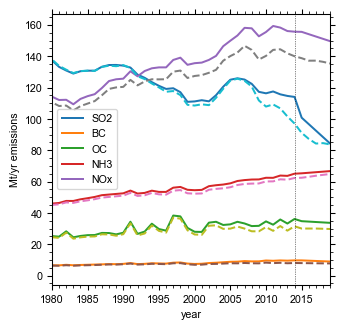

In [9]:
fig, ax = pl.subplots(figsize=(9.5/2.54,9.5/2.54))
#ax.set_prop_cycle(color=['blue', 'black', 'brown', 'green', 'orange'])
ax.plot(np.arange(1750,2101), emissions)
ax.plot(np.arange(1750,2020), emissions_ceds_update, ls='--')
pl.xlabel('year')
pl.ylabel('Mt/yr emissions')
pl.xlim(1980,2019)
pl.axvline(2014, color='k', ls=':', lw=0.5)
main_legend = ax.legend(labels=['SO2','BC','OC','NH3','NOx'])
#pl.savefig('../plots/eclipse_ssp.png')
#pl.savefig('../plots/eclipse_ssp.pdf')
#ax.legend(custom_lines, ['SSP Historical+SSP2-4.5', 'ECLIPSE v6b'])

In [10]:
df = pd.read_csv('../data_input_large/ERFari_samples.csv')
ari_coeffs = df.values

df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

samples =25000

In [11]:
# Use Nicolas' Ringberg methods, from script provided to me
def uniform1684(a,b,seed,samples=2000):
    interval = (b-a)+((b-a)/(84-16)*32)
    lower = a-((b-a)/(84-16)*16)
    return st.uniform.rvs(lower, interval, size=samples, random_state=seed)
#samples=500
dtau    = uniform1684(0.02,0.04,123,samples=samples)
tau     = uniform1684(0.13,0.17,124,samples=samples)
S_tau   = uniform1684(-27,-20,125,samples=samples)
RFari_cloudy = uniform1684(-0.1,0.1,126,samples=samples)
dR_dRatm = uniform1684(-0.3,-0.1,127,samples=samples)
dRatm_dtau = uniform1684(17,35,128,samples=samples)
c_tau    = uniform1684(0.59,0.71,129,samples=samples)
c_N      = uniform1684(0.19,0.29,130,samples=samples)
c_L      = uniform1684(0.21,0.29,131,samples=samples)
c_C      = uniform1684(0.59,1.07,132,samples=samples)
beta_N_tau = uniform1684(0.3,0.8,133,samples=samples)
beta_L_N   = uniform1684(-0.36,-0.011,134,samples=samples)
beta_C_N   = uniform1684(0,0.1,135,samples=samples)
S_N = uniform1684(-27,-26,136,samples=samples)
S_L = uniform1684(-56,-54,137,samples=samples)
S_C = uniform1684(-153,-91,138,samples=samples)

rfari = dtau*S_tau*(1-c_tau)+RFari_cloudy
rfari_adj = dtau*dR_dRatm*dRatm_dtau

dlntau = dtau/tau
deltan = dlntau * beta_N_tau

rfaci = dlntau*beta_N_tau*S_N*c_N
erfaci_L = dlntau*beta_N_tau*beta_L_N*S_L*c_L
erfaci_C = dlntau*beta_N_tau*beta_C_N*S_C*c_C

ERFari_scale = rfari + rfari_adj
ERFaci_scale = rfaci + erfaci_L + erfaci_C

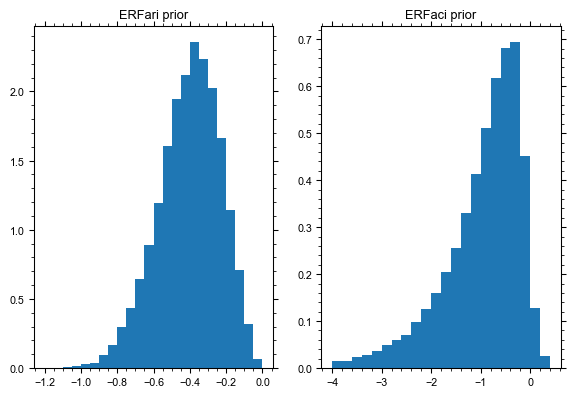

In [12]:
fig,ax = pl.subplots(1,2, figsize=(18/2.54,12/2.54))
ax[0].hist(ERFari_scale, bins=np.arange(-1.2,0.05,0.05), density=True);
ax[0].set_title('ERFari prior');
ax[1].hist(ERFaci_scale, bins=np.arange(-4,0.5,0.2), density=True);
ax[1].set_title('ERFaci prior');

In [13]:
# Define our dicts
ERFari = {}
ERFaci = {}

In [14]:
ERFari['CEDS-UPDATE'] = np.zeros((270,samples))
for i in tqdm_notebook(range(samples)):
    ts2010 = np.mean(
        aerocom_n(
            [
                emissions_ceds_update.loc[2005:2015,'BC'],
                emissions_ceds_update.loc[2005:2015,'OC'],
                emissions_ceds_update.loc[2005:2015,'SO2'],
                    1.0*emissions_ceds_update.loc[2005:2015, 'NH3']+
                    0.0*emissions_ceds_update.loc[2005:2015, 'NOx'],
            ], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0], ari_coeffs[i,3]
        )
    )
    ts1850 = aerocom_n(
        [
            emissions_ceds_update.loc[1850,'BC'],
            emissions_ceds_update.loc[1850,'OC'],
            emissions_ceds_update.loc[1850,'SO2'],
                1.0*emissions_ceds_update.loc[1850, 'NH3']+
                0.0*emissions_ceds_update.loc[1850, 'NOx'],
        ], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0], ari_coeffs[i,3]
    )
    ts1750 = aerocom_n(
        [
            emissions_ceds_update.loc[1750,'BC'],
            emissions_ceds_update.loc[1750,'OC'],
            emissions_ceds_update.loc[1750,'SO2'],
                1.0*emissions_ceds_update.loc[1750, 'NH3']+
                0.0*emissions_ceds_update.loc[1750, 'NOx'],
        ], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0], ari_coeffs[i,3]
    )
    ERFari['CEDS-UPDATE'][:,i] = (
        aerocom_n(
            [
                emissions_ceds_update['BC'],
                emissions_ceds_update['OC'],
                emissions_ceds_update['SO2'],
                1.0*emissions_ceds_update['NH3']+0.0*emissions_ceds_update['NOx']
            ], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0], ari_coeffs[i,3]
        )
    - ts1750)/(ts2010-ts1850)*ERFari_scale[i]

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [15]:
ERFaci['CEDS-UPDATE'] = np.zeros((270,samples))
for i in tqdm_notebook(range(samples)):
    ts2010 = np.mean(
        shindell(
            [
                emissions_ceds_update.loc[2005:2015,'SO2'],
                    emissions_ceds_update.loc[2005:2015,'BC']+
                    emissions_ceds_update.loc[2005:2015,'OC'],
                emissions_ceds_update.loc[2005:2015, 'NH3']
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2]
        )
    )
    ts1850 = shindell(
            [
                emissions_ceds_update.loc[1850,'SO2'],
                    emissions_ceds_update.loc[1850,'BC']+
                    emissions_ceds_update.loc[1850,'OC'],
                emissions_ceds_update.loc[1850, 'NH3']
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2]
        )
    ts1750 = shindell(
            [
                emissions_ceds_update.loc[1750,'SO2'],
                    emissions_ceds_update.loc[1750,'BC']+
                    emissions_ceds_update.loc[1750,'OC'],
                emissions_ceds_update.loc[1750, 'NH3']
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2]
        )
    ERFaci['CEDS-UPDATE'][:,i] = (
        shindell(
            [
                emissions_ceds_update['SO2'],
                    emissions_ceds_update['BC']+
                    emissions_ceds_update['OC'],
                emissions_ceds_update['NH3']
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2]
        )
    - ts1750)/(ts2010-ts1850)*ERFaci_scale[i]

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


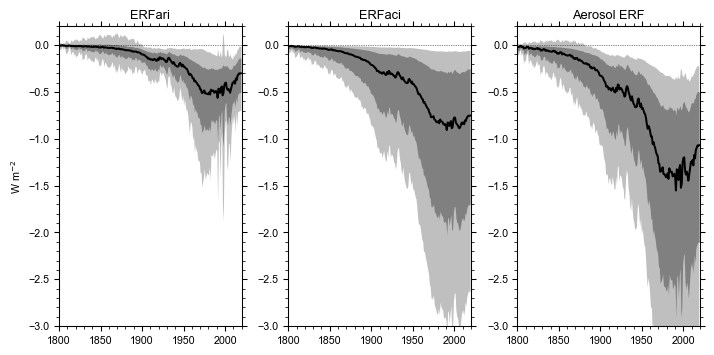

In [16]:
fig, ax = pl.subplots(1,3,figsize=(19/2.54, 9.5/2.54))
ax[0].fill_between(np.arange(1750,2020), np.percentile(ERFari['CEDS-UPDATE'], 5, axis=1), np.percentile(ERFari['CEDS-UPDATE'], 95, axis=1), color='0.75', lw=0);
ax[0].fill_between(np.arange(1750,2020), np.percentile(ERFari['CEDS-UPDATE'], 16, axis=1), np.percentile(ERFari['CEDS-UPDATE'], 84, axis=1), color='0.5', lw=0);
ax[0].plot(np.arange(1750,2020), np.percentile(ERFari['CEDS-UPDATE'], 50, axis=1), color='k', zorder=10)
ax[0].set_xlim(1800,2020)
ax[0].set_title('ERFari')
ax[0].set_ylabel('W m$^{-2}$')

ax[1].fill_between(np.arange(1750,2020), np.percentile(ERFaci['CEDS-UPDATE'], 5, axis=1), np.percentile(ERFaci['CEDS-UPDATE'], 95, axis=1), color='0.75', lw=0, label='5-95% range');
ax[1].fill_between(np.arange(1750,2020), np.percentile(ERFaci['CEDS-UPDATE'], 16, axis=1), np.percentile(ERFaci['CEDS-UPDATE'], 84, axis=1), color='0.5', lw=0, label='16-84% range');
ax[1].plot(np.arange(1750,2020), np.percentile(ERFaci['CEDS-UPDATE'], 50, axis=1), color='k', label='median', zorder=10)
ax[1].set_xlim(1800,2020)
ax[1].set_title('ERFaci')

ax[2].fill_between(np.arange(1750,2020), np.percentile(ERFari['CEDS-UPDATE']+ERFaci['CEDS-UPDATE'], 5, axis=1), np.percentile(ERFari['CEDS-UPDATE']+ERFaci['CEDS-UPDATE'], 95, axis=1), color='0.75', lw=0);
ax[2].fill_between(np.arange(1750,2020), np.percentile(ERFari['CEDS-UPDATE']+ERFaci['CEDS-UPDATE'], 16, axis=1), np.percentile(ERFari['CEDS-UPDATE']+ERFaci['CEDS-UPDATE'], 84, axis=1), color='0.5', lw=0);
ax[2].plot(np.arange(1750,2020), np.percentile(ERFari['CEDS-UPDATE']+ERFaci['CEDS-UPDATE'], 50, axis=1), color='k', zorder=10)
ax[2].set_xlim(1800,2020)
ax[2].set_title('Aerosol ERF')

ax[0].set_ylim(-3,0.2)
ax[1].set_ylim(-3,0.2)
ax[2].set_ylim(-3,0.2)
ax[0].axhline(0, ls=':', lw=0.5, color='k')
ax[1].axhline(0, ls=':', lw=0.5, color='k')
ax[2].axhline(0, ls=':', lw=0.5, color='k')

fig.tight_layout()

In [17]:
save_dict_to_hdf5(ERFari, '../data_input_large/ERFari.h5')
save_dict_to_hdf5(ERFaci, '../data_input_large/ERFaci.h5')